In [ ]:
# Install this (run the cell):
# !apt-get install openjdk-8-jdk-headless -qq
# !pip install pyspark

### Here I am analyzing just "business.pkl", "review.json" and "user.parquet"
### I am not analyzing "checkin.json" and "tip.json"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import input_file_name, regexp_extract
import matplotlib.pyplot as plt

# business.pkl

Observations:
- There are 150.346 rows and 28 (14) columns.
- Columns are repeated twice!
- Aparently there is no duplicate
- Everything is object type. 'stars', 'latitude' and 'longitude' columns should be float type, 'review_count' and 'is_open' columns integer type
- There are null values in columns: state(3), attributes(13744), categories(103), hours(23223)
- There are a few places with relatively much more reviews (possible outliers).
- Seems like there are many reviews between 2.5 and 4.5 stars and less between 1 and 2, and specifically 5

In [7]:
# Define the path pattern for the Pickle file
yelp_business_file_path = '/content/drive/MyDrive/Yelp/business.pkl'
yelp_business = pd.read_pickle(yelp_business_file_path)

## General Analysis

In [8]:
rows, columns = yelp_business.shape
f'There are {rows} rows and {columns} columns.'

'There are 150346 rows and 28 columns.'

In [9]:
yelp_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
yelp_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'business_id', 'name', 'address',
       'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars',
       'review_count', 'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [11]:
yelp_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150346 entries, 0 to 150345
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150343 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
 11  attributes    136602 non-null  object
 12  categories    150243 non-null  object
 13  hours         127123 non-null  object
 14  business_id   5 non-null       object
 15  name          5 non-null       object
 16  address       5 non-null       object
 17  city          5 non-null       object
 18  state         5 non-null

## Drop extra columns and change data types

In [12]:
index_to_drop = 14
yelp_business = yelp_business.iloc[:, :index_to_drop]

yelp_business['stars'] = yelp_business['stars'].astype(float)
yelp_business['review_count'] = yelp_business['review_count'].astype(int)
yelp_business['is_open'] = yelp_business['is_open'].astype(int)
yelp_business['latitude'] = yelp_business['latitude'].astype(float)
yelp_business['longitude'] = yelp_business['longitude'].astype(float)

<ipython-input-12-1ebe192ae53a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_business['stars'] = yelp_business['stars'].astype(float)


In [13]:
yelp_business.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


## Null values analysis

business_id         0
name                0
address             0
city                0
state               3
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64


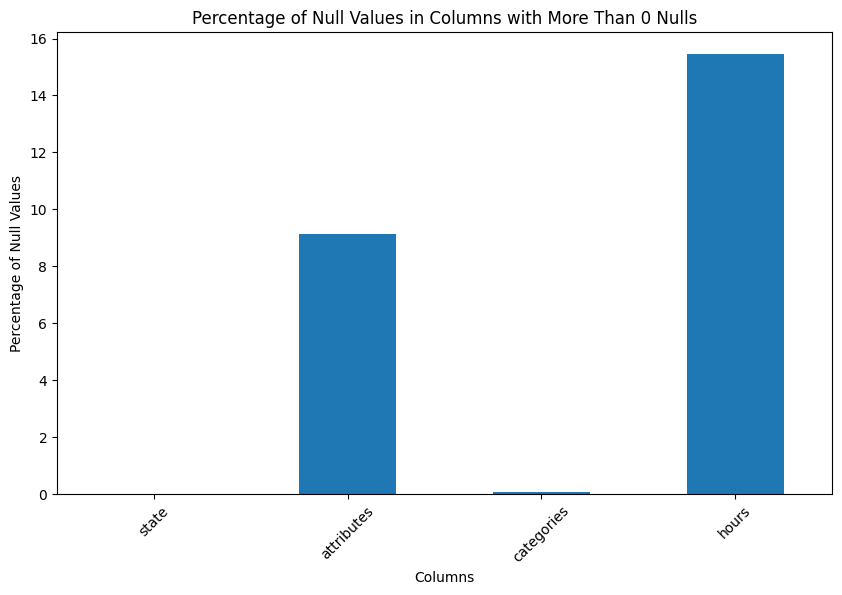

In [14]:
# Number of nulls per column
print(yelp_business.isnull().sum())
# Calculate the percentage of null values in each column
null_percentages = (yelp_business.isnull().sum() / len(yelp_business)) * 100
# Filter the null_percentages series to include only columns with more than 0 nulls
filtered_null_percentages = null_percentages[null_percentages > 0]
# Create a bar plot to visualize the percentages of null values for filtered columns
filtered_null_percentages.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.title('Percentage of Null Values in Columns with More Than 0 Nulls')
plt.xticks(rotation=45)
plt.show()

## Duplicates analysis

In [15]:
yelp_business_no_dict = yelp_business.drop(['attributes', 'categories', 'hours'], axis=1)
yelp_business_no_dict.duplicated().sum()

0

## Check 'is_open' column and coordenates columns integrity

In [16]:
is_open_values = yelp_business['is_open'].unique()
if len(is_open_values) == 2 and set(is_open_values) == {0, 1}:
    print("The 'is_open' column contains only 0 and 1 values.")
else:
    print("The 'is_open' column contains inconsistent values.")

The 'is_open' column contains only 0 and 1 values.


In [17]:
latitude_range = (yelp_business['latitude'].between(-90, 90)).all()
longitude_range = (yelp_business['longitude'].between(-180, 180)).all()

if latitude_range and longitude_range:
    print("The latitude and longitude values fall within valid ranges for the United States.")
else:
    print("There are latitude or longitude values outside the valid ranges for the United States.")


The latitude and longitude values fall within valid ranges for the United States.


## Visuals

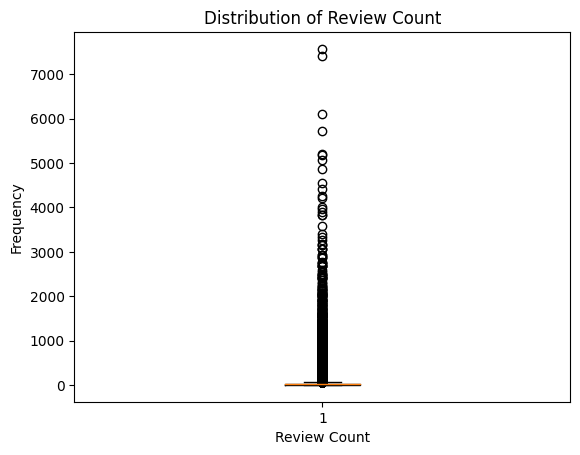

In [18]:
# Plotting boxplot for "review_count"
plt.boxplot(yelp_business['review_count'])
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Count')
plt.show()

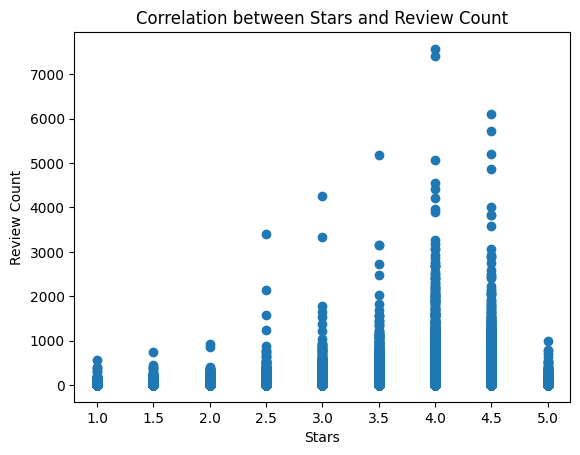

In [19]:
plt.scatter(yelp_business['stars'], yelp_business['review_count'])
plt.xlabel('Stars')
plt.ylabel('Review Count')
plt.title('Correlation between Stars and Review Count')
plt.show()

# review.json

Observations:
- There are 6.990.280 rows and 9 columns.
- Seems to be no null or duplicated value
- date column is string type

In [20]:
# Define the path pattern for the JSON file
yelp_review_file_path = '/content/drive/MyDrive/Yelp/review.json'

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the JSON files into Spark DataFrames
yelp_reviews = spark.read.json(yelp_review_file_path)

In [21]:
yelp_reviews.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [22]:
# Get the shape (number of rows and columns) of the DataFrame:
rows, columns = (yelp_reviews.count(), len(yelp_reviews.columns))
f'There are {rows} rows and {columns} columns.'

'There are 6990280 rows and 9 columns.'

In [23]:
# To get information about the DataFrame, including column data types and null counts:
yelp_reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [24]:
# To count the number of null values in each column:
yelp_reviews.select([sum(col(c).isNull().cast("int")).alias(c) for c in yelp_reviews.columns]).show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [25]:
# To count the number of duplicated rows in the DataFrame:
yelp_reviews.groupBy(yelp_reviews.columns).count().filter("count > 1").count()

0

In [26]:
yelp_reviews.describe()

DataFrame[summary: string, business_id: string, cool: string, date: string, funny: string, review_id: string, stars: string, text: string, useful: string, user_id: string]

In [27]:
numerical_cols = ['cool', 'funny', 'stars', 'useful']
yelp_reviews.select(numerical_cols).describe().show()

+-------+------------------+-------------------+------------------+------------------+
|summary|              cool|              funny|             stars|            useful|
+-------+------------------+-------------------+------------------+------------------+
|  count|           6990280|            6990280|           6990280|           6990280|
|   mean|0.4986175088837643|0.32655959417934616|  3.74858374771826|1.1846089140921394|
| stddev|2.1724598202111864| 1.6887290985540495|1.4787045052556855| 3.253766966933363|
|    min|                -1|                 -1|               1.0|                -1|
|    max|               404|                792|               5.0|              1182|
+-------+------------------+-------------------+------------------+------------------+



# user.parquet

Observations:
- There are 2.105.597 rows and 22 columns.
- Seems to be no null
- Seems to be 117.700 duplicated values
- I do not know if there are outliers

In [28]:
# Define the path pattern for the JSON file
yelp_user_file_path = '/content/drive/MyDrive/Yelp/user.parquet'

# Read the JSON files into Spark DataFrames
yelp_user = pd.read_parquet(yelp_user_file_path)

In [29]:
rows, columns = yelp_user.shape
f'There are {rows} rows and {columns} columns.'

'There are 2105597 rows and 22 columns.'

In [30]:
yelp_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [31]:
yelp_user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [32]:
yelp_user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06,2.105597e+06
mean,2.846875e+01,5.516853e+01,2.267667e+01,3.143013e+01,1.913746e+00,3.641863e+00,2.444596e+00,3.968618e-01,2.532631e-01,1.858665e-01,9.631663e-02,1.921464e+00,4.124809e+00,3.805567e+00,3.805567e+00,1.459133e+00,1.499514e+00
std,1.042146e+02,7.388068e+02,4.628811e+02,6.379274e+02,2.436510e+01,1.159519e+00,7.963704e+01,1.405658e+01,1.767698e+01,1.170051e+01,1.049796e+01,6.177753e+01,1.364953e+02,1.057484e+02,1.057484e+02,3.676692e+01,9.607754e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.880000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.900000e+01,1.500000e+01,3.000000e+00,4.000000e+00,0.000000e+00,4.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.747300e+04,2.062960e+05,1.858230e+05,1.998780e+05,1.249700e+04,5.000000e+00,2.578400e+04,1.350100e+04,1.418000e+04,1.365400e+04,1.266900e+04,5.903100e+04,1.010970e+05,4.996700e+04,4.996700e+04,1.593400e+04,8.263000e+04


In [33]:
yelp_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105597 entries, 0 to 2105596
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 353.4+ MB


In [34]:
yelp_user.duplicated().sum()

117700